# Setup dependencies / Set up GPU acceleration

In [120]:
import tensorflow as tf
import os

In [121]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [122]:
#!pip list # used to make sure correct version of tensorflow is installed for gpu acceleration

In [123]:
gpus = tf.config.experimental.list_physical_devices('GPU')

In [124]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 1.0 Load and Visualize Data

# 1.1 import flower dataset

In [423]:
from tensorflow import keras

In [424]:
path_train = "Datasets/Flower_dataset/train"

In [425]:
os.listdir(path_train)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [438]:
data = tf.keras.utils.image_dataset_from_directory(path_train,image_size = (128,128),batch_size = 32)

Found 2747 files belonging to 5 classes.


In [439]:
data_iterator = data.as_numpy_iterator()

In [440]:
batch = data_iterator.next()

In [441]:
labels_list = sorted(os.listdir(path_train))
label_dictionary = {labels_list[i]:i for i in range(len(labels_list))}
label_dictionary

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

# 1.2 Visualize data using matplotlib

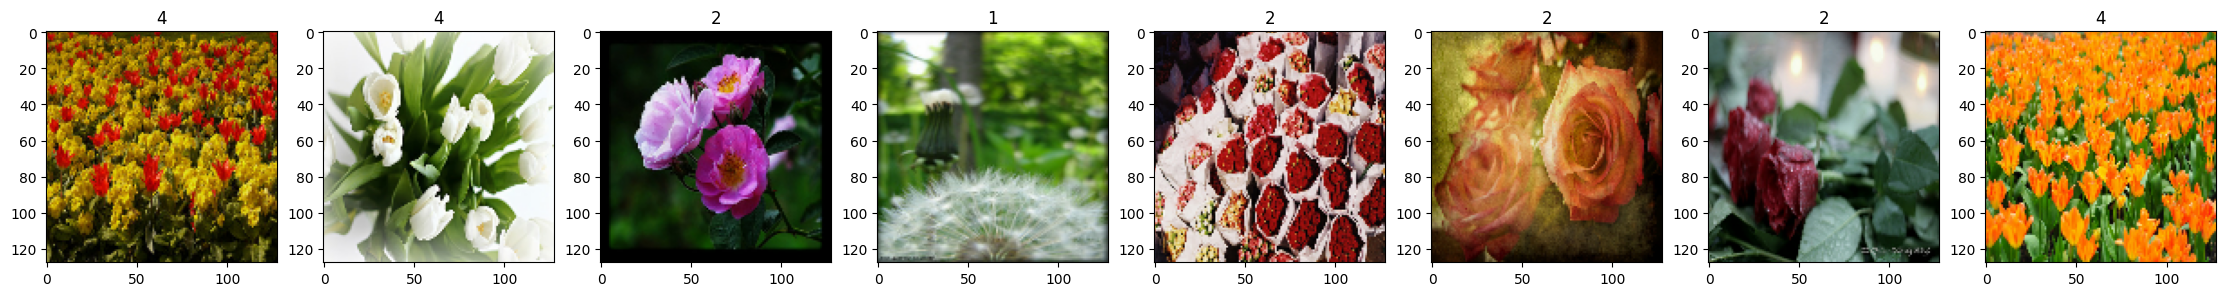

In [442]:
fig,ax = plt.subplots(ncols = 8, figsize = (28,28))
rows = 0
for idx,img in enumerate(batch[0][:8]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 1.3 Apply normalization --> all pixels between 0 - 1

In [443]:
data = data.map(lambda x,y: (x/255,y))

In [444]:
data_iterator = data.as_numpy_iterator()

In [445]:
batch = data_iterator.next()
batch[0].shape

(32, 128, 128, 3)

# 1.4 Create train/test/val data 

### train size ~ 2240 images
### val size ~ 256 images
### test size ~ 256 images

In [446]:
len(data)

86

In [447]:
train_size = int(len(data) * .8) + 2
print(train_size)
val_size = int(len(data) * .10)
print(val_size)
test_size = int(len(data) * .10)
print(test_size)

70
8
8


In [448]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

# 2 Build CNN model

In [449]:
from tensorflow.keras.models import Sequential

In [450]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, MaxPooling2D, BatchNormalization, ReLU, Dropout

In [451]:
from tensorflow.keras.regularizers import l2

In [567]:
def Model():
    model = Sequential()

    # First Layer
    model.add(Conv2D(64,(2,2),1,activation = "relu",padding = "same",input_shape = (128,128,3),kernel_regularizer = l2(0.001)))
    model.add(MaxPooling2D())

    # Second Layer
    model.add(Conv2D(128,(2,2),1,activation = "relu",padding = "same"))
    model.add(MaxPooling2D())

    #Third layer
    model.add(Conv2D(256,(2,2),1,activation = "relu",padding = "same",kernel_regularizer = l2(0.001)))
    model.add(MaxPooling2D())
    
    # Fith Layer
    model.add(Flatten())
    model.add(Dense(128,activation = "relu",kernel_regularizer = l2(0.001)))
    model.add(Dropout(0.5))

    # Final layer
    model.add(Dense(5,activation = "softmax"))
    return model


In [568]:
model = Model()
model.compile('adam',loss = 'sparse_categorical_crossentropy',metrics=['accuracy'])

In [569]:
model.summary()

Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_149 (Conv2D)         (None, 128, 128, 64)      832       
                                                                 
 max_pooling2d_147 (MaxPooli  (None, 64, 64, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_150 (Conv2D)         (None, 64, 64, 128)       32896     
                                                                 
 max_pooling2d_148 (MaxPooli  (None, 32, 32, 128)      0         
 ng2D)                                                           
                                                                 
 conv2d_151 (Conv2D)         (None, 32, 32, 256)       131328    
                                                                 
 max_pooling2d_149 (MaxPooli  (None, 16, 16, 256)    

# 3 Train the model

In [570]:
results = 'results'

In [571]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=results)

In [572]:
hist = model.fit(train,epochs=20,validation_data=val, callbacks = [tensorboard_callback])

Epoch 1/20
70/70 [==============================] - 2s 28ms/step - loss: 1.6036 - accuracy: 0.4071 - val_loss: 1.3278 - val_accuracy: 0.5742
Epoch 2/20
70/70 [==============================] - 2s 26ms/step - loss: 1.2822 - accuracy: 0.5397 - val_loss: 1.1237 - val_accuracy: 0.6484
Epoch 3/20
70/70 [==============================] - 2s 27ms/step - loss: 1.1595 - accuracy: 0.6170 - val_loss: 1.2068 - val_accuracy: 0.5586
Epoch 4/20
70/70 [==============================] - 2s 26ms/step - loss: 1.1000 - accuracy: 0.6313 - val_loss: 1.0993 - val_accuracy: 0.6055
Epoch 5/20
70/70 [==============================] - 2s 26ms/step - loss: 1.0081 - accuracy: 0.6607 - val_loss: 1.0971 - val_accuracy: 0.6289
Epoch 6/20
70/70 [==============================] - 2s 26ms/step - loss: 0.9754 - accuracy: 0.6862 - val_loss: 1.0490 - val_accuracy: 0.6914
Epoch 7/20
70/70 [==============================] - 2s 26ms/step - loss: 0.9587 - accuracy: 0.7027 - val_loss: 1.0870 - val_accuracy: 0.6406
Epoch 8/20
70

# 3.1 Model evaulation

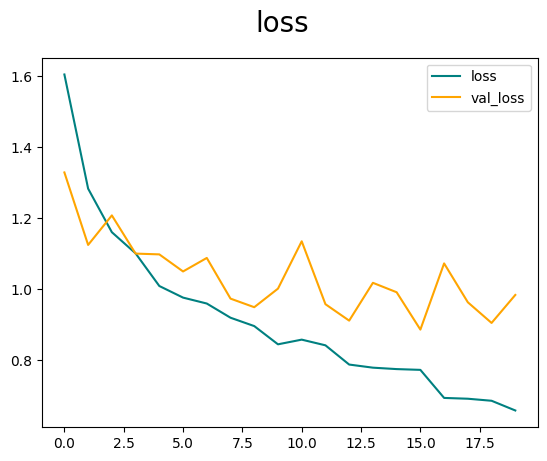

In [573]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'teal', label = "loss")
plt.plot(hist.history['val_loss'], color = 'orange', label = "val_loss")
fig.suptitle('loss', fontsize = 20)
plt.legend()
plt.show()

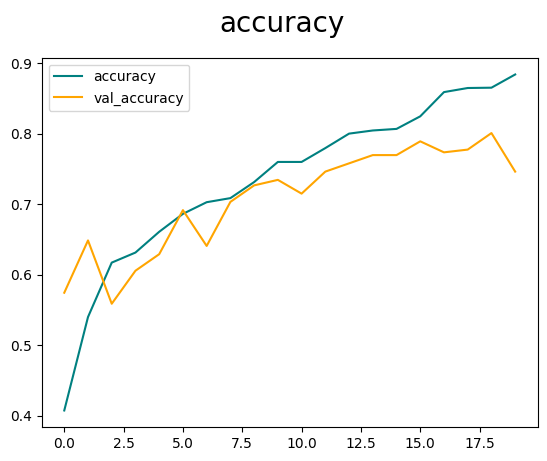

In [574]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color = 'teal', label = "accuracy")
plt.plot(hist.history['val_accuracy'], color = 'orange', label = "val_accuracy")
fig.suptitle('accuracy', fontsize = 20)
plt.legend()
plt.show()

# 4 Test on test set

In [575]:
l = a = c = 0
for batch in test.as_numpy_iterator():
    X,y = batch
    loss,accuracy = model.evaluate(X,y)
    l += loss
    a += accuracy
    c += 1
    

1/1 [==============================] - 0s 20ms/step - loss: 1.2979 - accuracy: 0.7407


In [576]:
print("average loss = ",l / c)

average loss =  1.0402503982186317


In [577]:
print("average accuracy = ",a / c)

average accuracy =  0.7410300895571709


# 5 Interpret results and save

In [587]:
model.save("CNN_model_of_184.h5")

# Build MLP model 

In [578]:
def model_MLP():
    model = Sequential()
    
    model.add(Flatten(input_shape = (128,128,1)))
    model.add(Dense(256,activation = "ReLU"))
    model.add(Dropout(0.2))

    model.add(Dense(128,activation = "ReLU"))
    model.add(Dropout(0.2))

    model.add(Dense(5,activation = "softmax"))

    return model
    

    

In [579]:
MLP = model_MLP() 
MLP.compile('adam',loss = 'sparse_categorical_crossentropy',metrics=['accuracy'])

In [580]:
MLP.summary()

Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_57 (Flatten)        (None, 16384)             0         
                                                                 
 dense_115 (Dense)           (None, 256)               4194560   
                                                                 
 dropout_58 (Dropout)        (None, 256)               0         
                                                                 
 dense_116 (Dense)           (None, 128)               32896     
                                                                 
 dropout_59 (Dropout)        (None, 128)               0         
                                                                 
 dense_117 (Dense)           (None, 5)                 645       
                                                                 
Total params: 4,228,101
Trainable params: 4,228,101
N

In [581]:
results_MLP = 'results_MLP'

In [582]:
tensorboard_callback_MLP = tf.keras.callbacks.TensorBoard(log_dir=results_MLP)

In [583]:
hist_MLP = model.fit(train,epochs=20,validation_data=val, callbacks = [tensorboard_callback_MLP])

Epoch 1/20
70/70 [==============================] - 2s 26ms/step - loss: 0.6268 - accuracy: 0.8857 - val_loss: 0.9608 - val_accuracy: 0.7969
Epoch 2/20
70/70 [==============================] - 2s 26ms/step - loss: 0.5797 - accuracy: 0.9076 - val_loss: 0.8745 - val_accuracy: 0.8125
Epoch 3/20
70/70 [==============================] - 2s 26ms/step - loss: 0.5857 - accuracy: 0.9067 - val_loss: 0.7961 - val_accuracy: 0.8555
Epoch 4/20
70/70 [==============================] - 2s 26ms/step - loss: 0.6202 - accuracy: 0.8960 - val_loss: 0.9201 - val_accuracy: 0.8203
Epoch 5/20
70/70 [==============================] - 2s 26ms/step - loss: 0.6161 - accuracy: 0.9058 - val_loss: 1.1132 - val_accuracy: 0.8047
Epoch 6/20
70/70 [==============================] - 2s 26ms/step - loss: 0.6095 - accuracy: 0.9040 - val_loss: 0.9903 - val_accuracy: 0.7891
Epoch 7/20
70/70 [==============================] - 2s 26ms/step - loss: 0.5627 - accuracy: 0.9223 - val_loss: 0.9346 - val_accuracy: 0.8047
Epoch 8/20
70

In [584]:
l = a = c = 0
for batch in test.as_numpy_iterator():
    X,y = batch
    loss,accuracy = model.evaluate(X,y)
    l += loss
    a += accuracy
    c += 1

1/1 [==============================] - 0s 18ms/step - loss: 1.4147 - accuracy: 0.7778


In [585]:
print("average loss = ",l / c)

average loss =  1.1679046750068665


In [586]:
print("average accuracy = ",a / c)

average accuracy =  0.7730034738779068


In [588]:
MLP.save("MLP_model_of_184.h5")